# Sequence to Sequence Learning with Neural Networks

In this notebook, we'll be building a machine learning model to go from one sequence to another, using PyTorch and torchtext. This will be done on German to English translations, but the method can be applied to any problem that involves going from one sequence to another, such as summarization, i.e. going from a sequence to a shorter sequence in the same language.

In this notebook, weimplement the model from the [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) paper. 

## Introduction

The most common sequence-to-sequence (seq2seq) models are *encoder-decoder* models, which commonly use a *recurrent neural network* (RNN) to *encode* the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a *context vector*. We can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

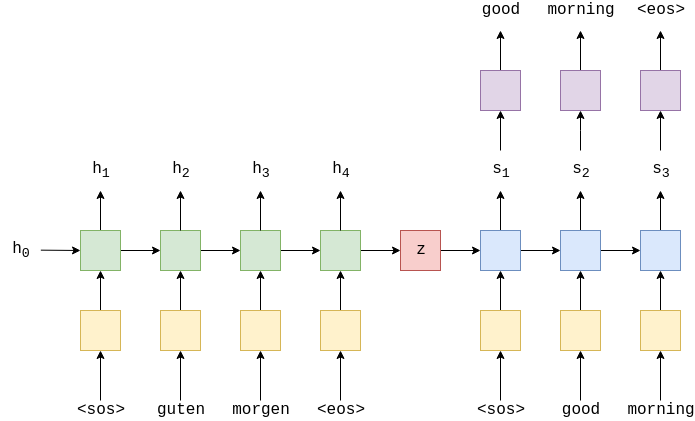

The above image shows an example translation. The input/source sentence, "guten morgen", is passed through the embedding layer (yellow) and then input into the encoder (green). We also append a *start of sequence* (`<sos>`) and *end of sequence* (`<eos>`) token to the start and end of sentence, respectively. At each time-step, the input to the encoder RNN is both the embedding, $e$, of the current word, $e(x_t)$, as well as the hidden state from the previous time-step, $h_{t-1}$, and the encoder RNN outputs a new hidden state $h_t$. We can think of the hidden state as a vector representation of the sentence so far. The RNN can be represented as a function of both of $e(x_t)$ and $h_{t-1}$:

$$h_t = \text{EncoderRNN}(e(x_t), h_{t-1})$$

We're using the term RNN generally here, it could be any recurrent architecture, such as an *LSTM* (Long Short-Term Memory) or a *GRU* (Gated Recurrent Unit). 

Here, we have $X = \{x_1, x_2, ..., x_T\}$, where $x_1 = \text{<sos>}, x_2 = \text{guten}$, etc. The initial hidden state, $h_0$, is usually either initialized to zeros or a learned parameter.

Once the final word, $x_T$, has been passed into the RNN via the embedding layer, we use the final hidden state, $h_T$, as the context vector, i.e. $h_T = z$. This is a vector representation of the entire source sentence.

Now we have our context vector, $z$, we can start decoding it to get the output/target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the decoder RNN (blue) is the embedding, $d$, of current word, $d(y_t)$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$, i.e. the initial decoder hidden state is the final encoder hidden state. Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(d(y_t), s_{t-1})$$

Although the input/source embedding layer, $e$, and the output/target embedding layer, $d$, are both shown in yellow in the diagram they are two different embedding layers with their own parameters.

In the decoder, we need to go from the hidden state to an actual word, therefore at each time-step we use $s_t$ to predict (by passing it through a `Linear` layer, shown in purple) what we think is the next word in the sequence, $\hat{y}_t$. 

$$\hat{y}_t = f(s_t)$$

The words in the decoder are always generated one after another, with one per time-step. We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t>1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called *teacher forcing*. 

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.


In [3]:
!pip install Torchtext==0.9
#torchtext.legacy is not supported on the defult version

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import numpy as np
import spacy
import random
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from utils import translate_sentence, bleu, save_checkpoint, load_checkpoint

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is a token, not a word. 

spaCy has model for each language ("de_core_news_sm" for German and "en_core_web_sm" for English) which need to be loaded so we can access the tokenizer of each model. 

**Note**: the models must first be downloaded using the following on the command line: 
```
python -m spacy download en_core_web_sm
python -m spacy download de_core_news_sm
```

We load the models as such:

In [5]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")


spacy_ger = spacy.load('de_core_news_sm')
spacy_eng = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


Next, we create the tokenizer functions. These can be passed to torchtext and will take in the sentence as a string and return the sentence as a list of tokens.

In [6]:
def tokenize_ger(text):
    return [tok.text for tok in spacy_ger.tokenizer(text)]


def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]

torchtext's `Field`s handle how data should be processed.  

We set the `tokenize` argument to the correct tokenization function for each, with German being the source field and English being the target field. The field also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

In [7]:
german = Field(tokenize=tokenize_ger, lower=True, init_token="<sos>", eos_token="<eos>")

english = Field(
    tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>"
)

Next, we download and load the train, validation and test data. 

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset). This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence. 

`exts` specifies which languages to use as the source and target (source goes first) and `fields` specifies which field to use for the source and target.

In [9]:
train_data, valid_data, test_data = Multi30k.splits(
    exts=(".de", ".en"), fields=(german, english)
)

We can double check that we've loaded the right number of examples:

In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


Next, we'll build the *vocabulary* for the source and target languages. The vocabulary is used to associate each unique token with an index (an integer). The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

It is important to note that our vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

In [11]:
german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)

The final step of preparing the data is to create the iterators.

We also need to define a `torch.device`. This is used to tell torchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, torchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
batch_size = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

## Building the Seq2Seq Model

We'll be building our model in three parts. The encoder, the decoder and a seq2seq model that encapsulates the encoder and decoder and will provide a way to interface with each.

### Encoder

First, the encoder, a 2 layer LSTM. The paper we are implementing uses a 4-layer LSTM, but in the interest of training time we cut this down to 2-layers. The concept of multi-layer RNNs is easy to expand from 2 to 4 layers. 



In [14]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        return hidden, cell

### Decoder

Next, we'll build our decoder, which will also be a 2-layer (4 in the paper) LSTM.

In [15]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)

        return predictions, hidden, cell


### Seq2Seq

For the final part of the implemenetation, we'll implement the seq2seq model. This will handle: 
- receiving the input/source sentence
- using the encoder to produce the context vectors 
- using the decoder to produce the predicted output/target sentence


The `Seq2Seq` model takes in an `Encoder`, `Decoder`, and a `device` (used to place tensors on the GPU, if it exists).

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(english.vocab)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0]

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell = self.decoder(x, hidden, cell)

            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

# Training the Seq2Seq Model

Now we have our model implemented, we can begin training it. 

First, we'll initialize our model. As mentioned before, the input and output dimensions are defined by the size of the vocabulary. The embedding dimesions and dropout for the encoder and decoder can be different, but the number of layers and the size of the hidden/cell states must be the same. 

We then define the encoder, decoder and then our Seq2Seq model, which we place on the `device`.

In [ ]:
# Training hyperparameters
num_epochs = 100
learning_rate = 0.001



# Model hyperparameters
load_model = False


input_size_encoder = len(german.vocab)
input_size_decoder = len(english.vocab)
output_size = len(english.vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 1024  # Needs to be the same for both RNN's
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

# Tensorboard to get nice loss plot
writer = SummaryWriter(f"runs/loss_plot")
step = 0



encoder_net = Encoder(
    input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)


sentence = "ein boot mit mehreren männern darauf wird von einem großen pferdegespann ans ufer gezogen."

for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")

    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint)

    model.eval()

    translated_sentence = translate_sentence(
        model, sentence, german, english, device, max_length=50
    )

    print(f"Translated example sentence: \n {translated_sentence}")

    model.train()

    for batch_idx, batch in enumerate(train_iterator):
        # Get input and targets and get to cuda
        inp_data = batch.src.to(device)
        target = batch.trg.to(device)

        # Forward prop
        output = model(inp_data, target)

        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()

        # Plot to tensorboard
        writer.add_scalar("Training loss", loss, global_step=step)
        step += 1


score = bleu(test_data[1:100], model, german, english, device)
print(f"Bleu score {score*100:.2f}")

**Testing our translator:**

In [21]:
eng_sentence = 'A man with a blue shirt is running in the street'
sentence = 'Ein Mann mit blauem Hemd läuft auf der Straße.'
model.eval()

translated_sentence = translate_sentence(
    model, sentence, german, english, device, max_length=50)

print('Correct English translation: \n {}'.format(eng_sentence))
print(f"Translation by our machine: \n {translated_sentence}")

Correct English translation: 
 A man with a blue shirt is running in the street
Translation by our machine: 
 ['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'running', 'on', 'the', 'street', '.', '<eos>']
